In [2]:
library(DBI)
library(RSQLite)
library(dplyr)
library(ggplot2)
library(odbc)
library(ggcorrplot)



In [3]:
con <-dbConnect(odbc(),
                Driver="SQL Server", 
                Server= "DESKTOP-F1Q7Q52\\SQLEXPRESS",
                Database="BoxOffice",
                Trusted_connection = "True")

In [4]:
movies_ff <- dbReadTable(con,"movies_ff_v")


In [6]:
save(movies_ff,file="C:/Users/elile/Desktop/DS10/GITT/data/BoxOffice_ff1.RData")

In [7]:
load ("C:/Users/elile/Desktop/DS10/GITT/data/BoxOffice_ff1.RData")

In [26]:
movies_ff


movie_id,budget,original_language,popularity,release_date,runtime,runtime_cat,revenue,sw_lang_en,sw_web_presence,...,depart_Camera_female,depart_Crew_female,depart_Custom_Mkup_female,depart_Directing_female,depart_Editing_female,depart_Lighting_female,depart_Production_female,depart_Sound_female,depart_Visual_Effects_female,depart_Writing_female
<int>,<int>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,14000000,en,6.575393,2015-02-20,93,Short,12314651,1,0,...,0,0,0,0,0,0,0,0,0,0
2,40000000,en,8.248895,2004-08-06,113,Medium,95149435,1,0,...,0,0,0,0,0,0,3,0,0,1
3,3300000,en,64.299990,2014-10-10,105,Medium,13092000,1,1,...,0,1,0,0,0,0,2,0,0,0
4,1200000,hi,3.174936,2012-03-09,122,Large,16000000,0,1,...,0,0,0,0,0,0,0,0,0,0
5,0,ko,1.148070,2009-02-05,118,Medium,3923970,0,0,...,0,0,0,0,0,0,0,0,0,0
6,8000000,en,0.743274,1987-08-06,83,Short,3261638,1,0,...,0,0,0,0,0,0,0,0,0,0
7,14000000,en,7.286477,2012-08-30,92,Short,85446075,1,1,...,0,0,1,1,0,0,3,0,0,0
8,0,en,1.949044,2004-01-15,84,Short,2586511,1,0,...,0,0,0,1,0,0,0,0,0,0
9,0,en,6.902423,1996-02-16,100,Medium,34327391,1,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
BoxOffice<-movies_ff

In [32]:
summary(BoxOffice)

    movie_id        budget          original_language    popularity     
 Min.   :   1   Min.   :        0   Length:7375        Min.   :  0.000  
 1st Qu.:1848   1st Qu.:        0   Class :character   1st Qu.:  3.970  
 Median :3696   Median :  8000000   Mode  :character   Median :  7.456  
 Mean   :3698   Mean   : 22666657                      Mean   :  8.540  
 3rd Qu.:5550   3rd Qu.: 29000000                      3rd Qu.: 10.932  
 Max.   :7398   Max.   :380000000                      Max.   :547.488  
                                                                        
 release_date          runtime      runtime_cat           revenue         
 Length:7375        Min.   :  0.0   Length:7375        Min.   :1.000e+00  
 Class :character   1st Qu.: 94.0   Class :character   1st Qu.:2.405e+06  
 Mode  :character   Median :104.0   Mode  :character   Median :1.693e+07  
                    Mean   :107.7                      Mean   :6.688e+07  
                    3rd Qu.:118.0        

In [30]:

if(!require(ggExtra)) {install.packages("ggExtra");require(ggExtra)}
if(!require(naniar)) {install.packages("naniar");require(naniar)}
if(!require(mvoutlier)) {install.packages("mvoutlier");require(mvoutlier)}
if(!require(MissMech)) {install.packages("MissMech");require(MissMech)}
if(!require(mice)) {install.packages("mice");require(mice)}
if(!require(MatchIt)) {install.packages("MatchIt");require(MatchIt)}
if(!require(pastecs)) {install.packages("pastecs");require(ggExtra)}
if(!require(ggcorrplot)) {install.packages("ggcorrplot");require(ggcorrplot)}

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"NAs introduced by coercion"Warning message in min(x):
"no non-missing arguments to min; returning Inf"Warning message in max(x):
"no non-missing arguments to max; returning -Inf"

ERROR: Error in plot.window(...): need finite 'ylim' values


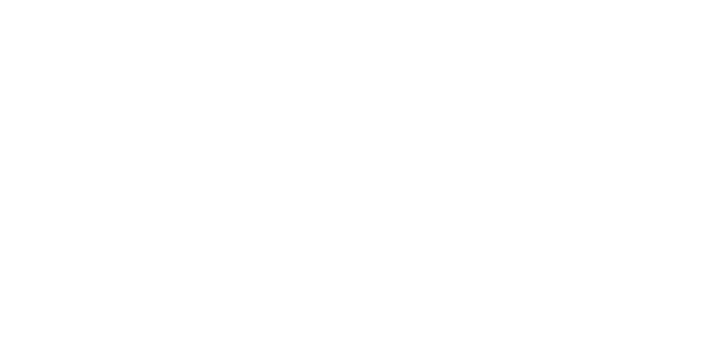

In [36]:
options(repr.plot.width = 6, repr.plot.height = 3)
plot(BoxOffice$runtime_cat)

Warning message:
"Removed 4382 rows containing non-finite values (stat_density)."

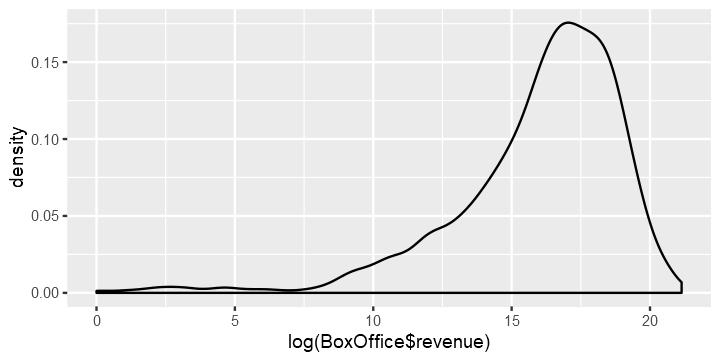

In [38]:
ggplot(data=BoxOffice) +
    geom_density(aes(log(BoxOffice$revenue)))

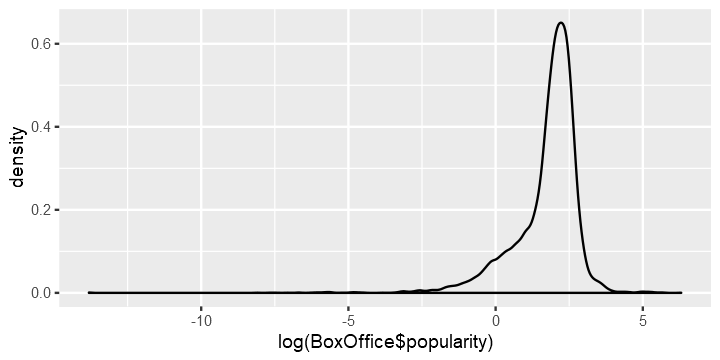

In [42]:
ggplot(data=BoxOffice) +
    geom_density(aes(log(BoxOffice$popularity)))

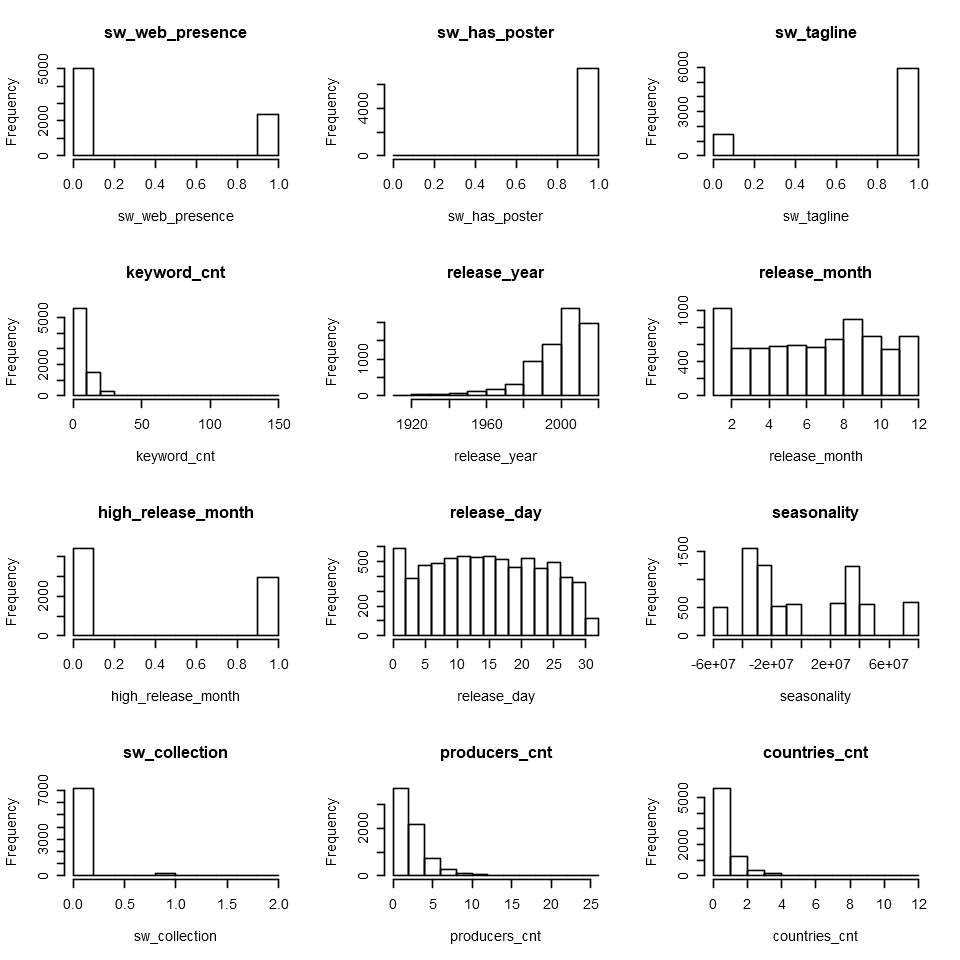

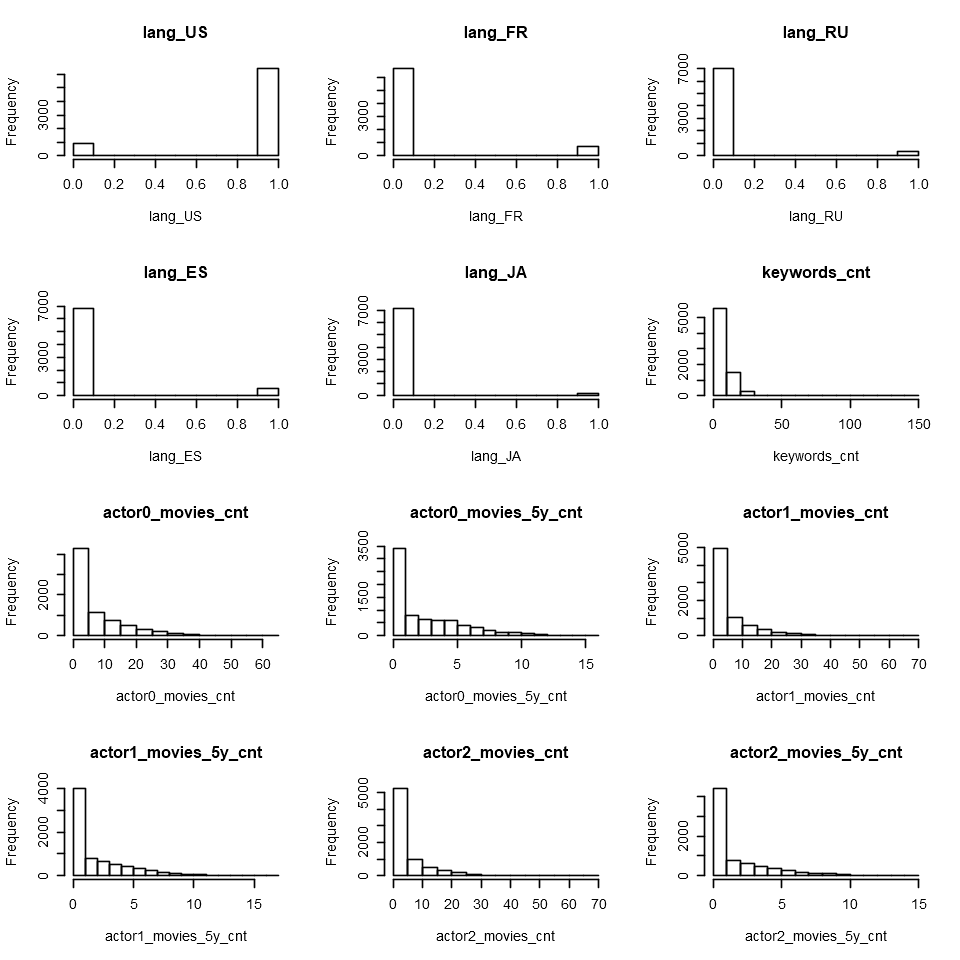

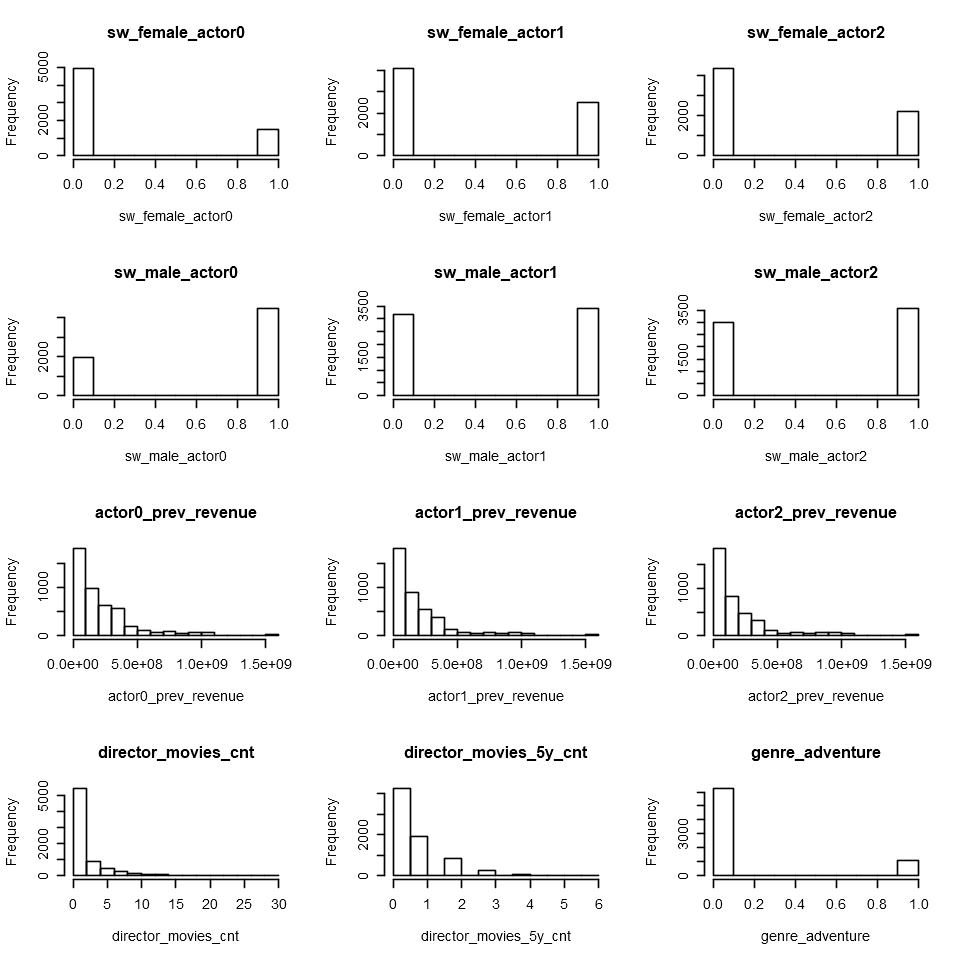

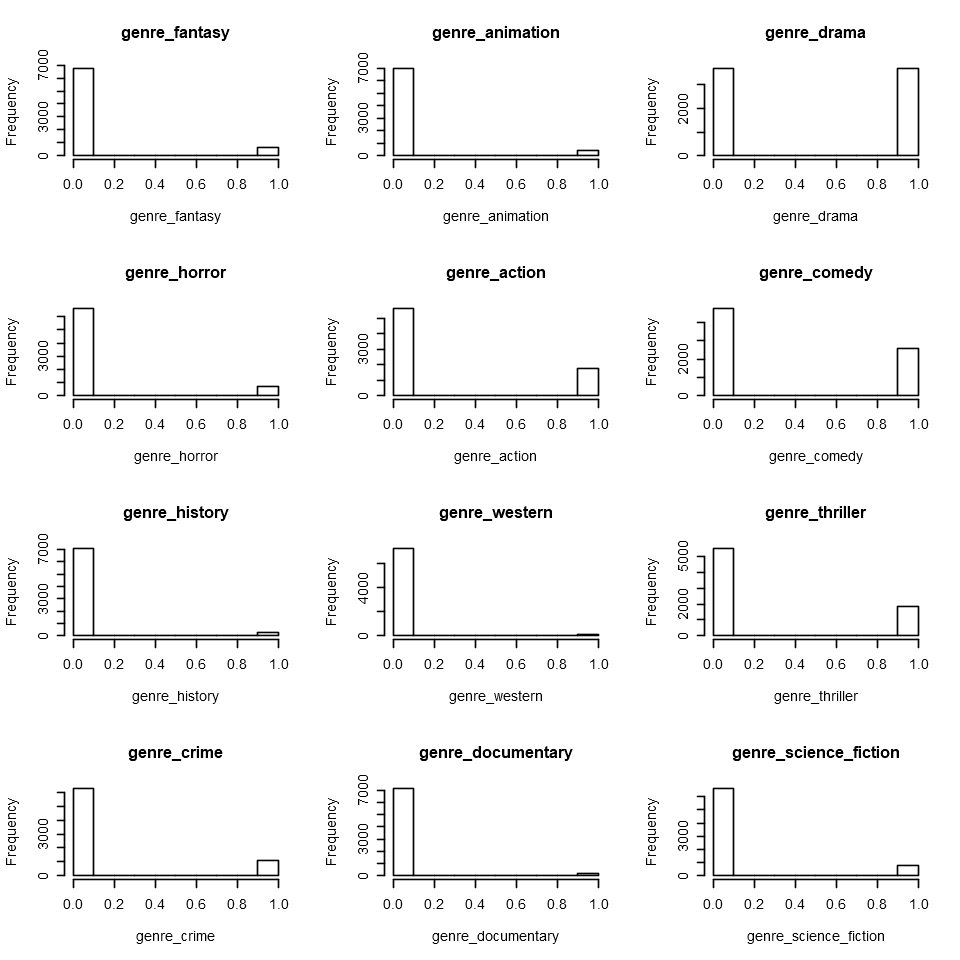

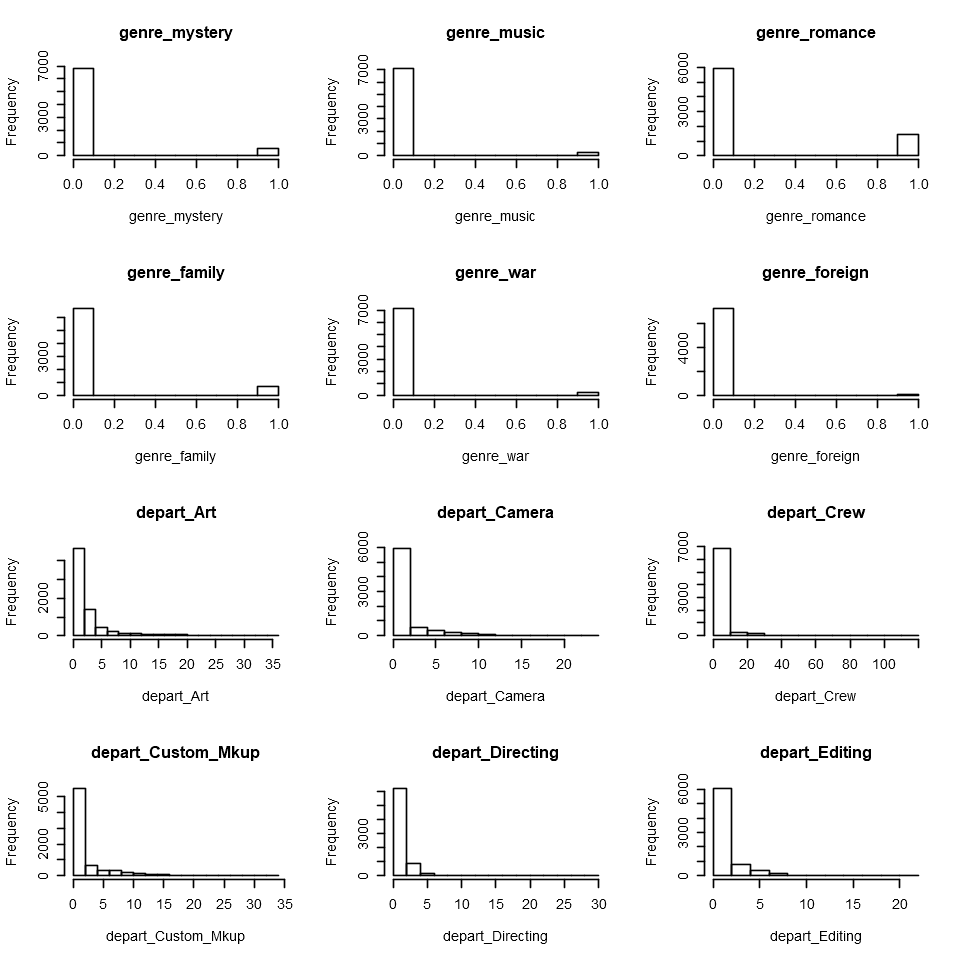

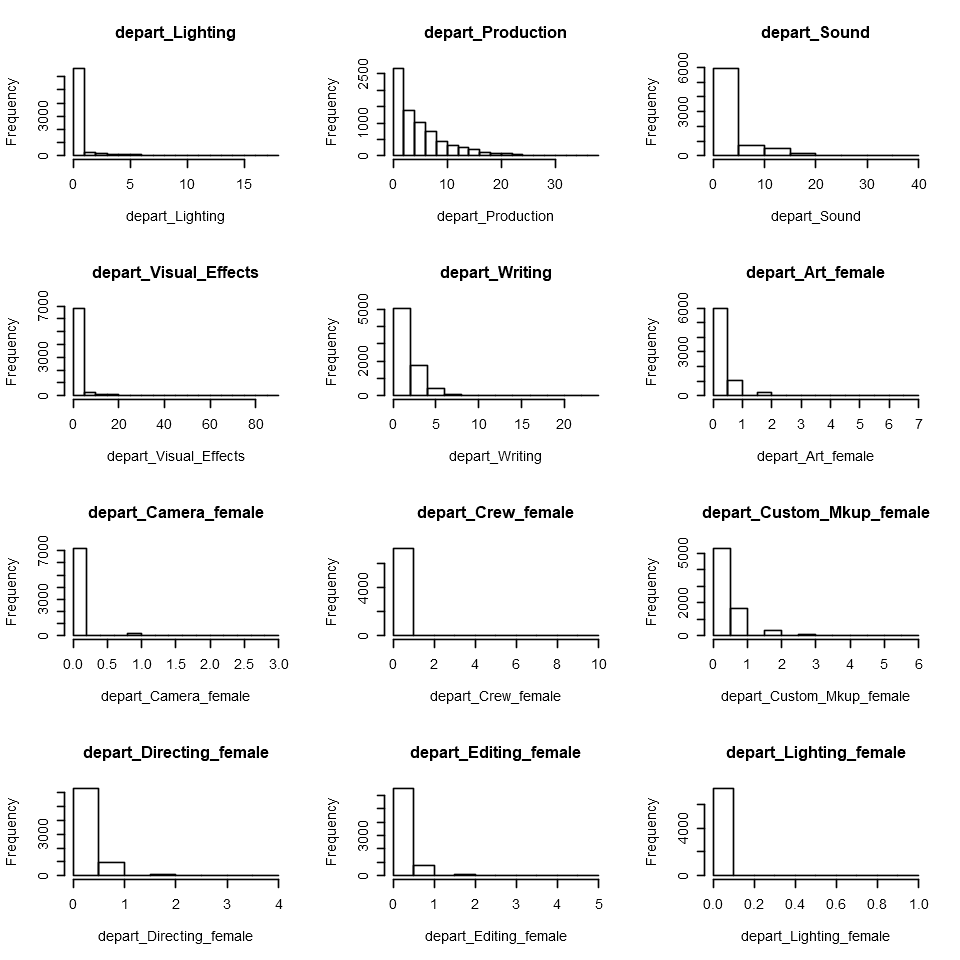

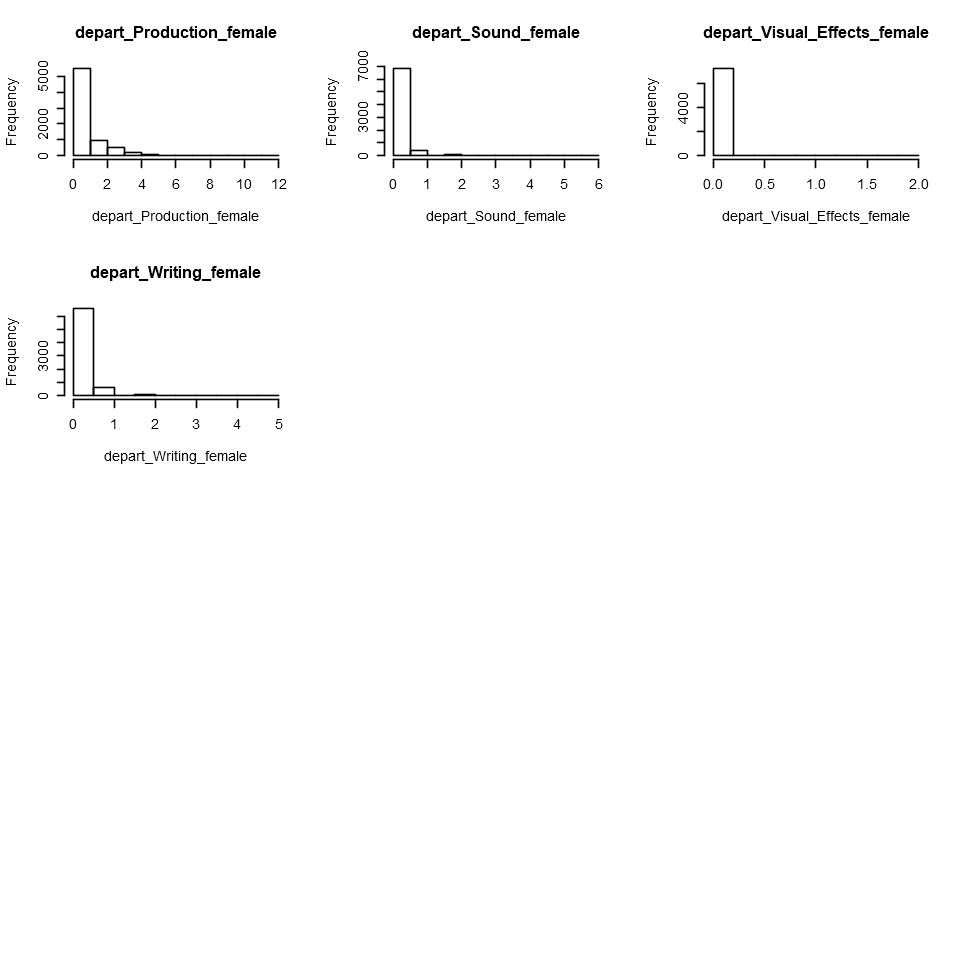

In [64]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
nm <- names(BoxOffice[,1:85])
for(i in 10:85){
    x<-BoxOffice[,i]
    hist (x,xlab=nm[i],main=nm[i])
    }


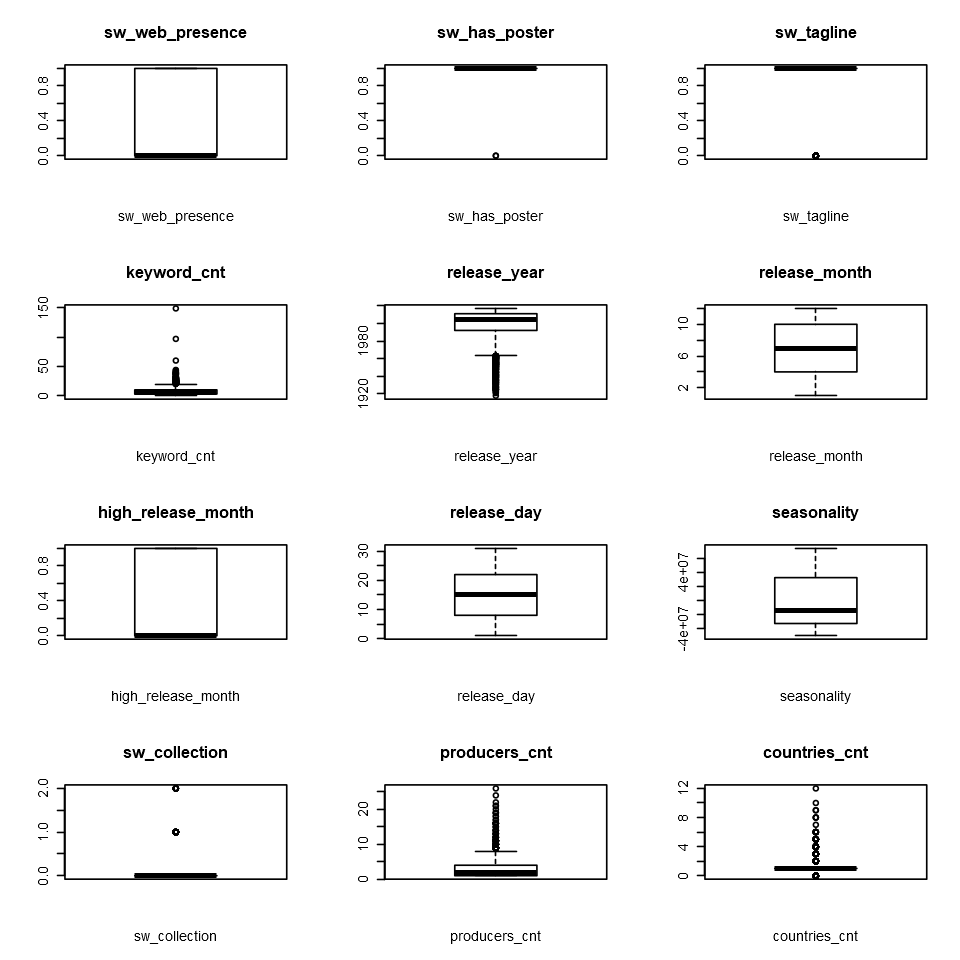

Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"Warning message in x[floor(d)] + x[ceiling(d)]:
"NAs produced by integer overflow"

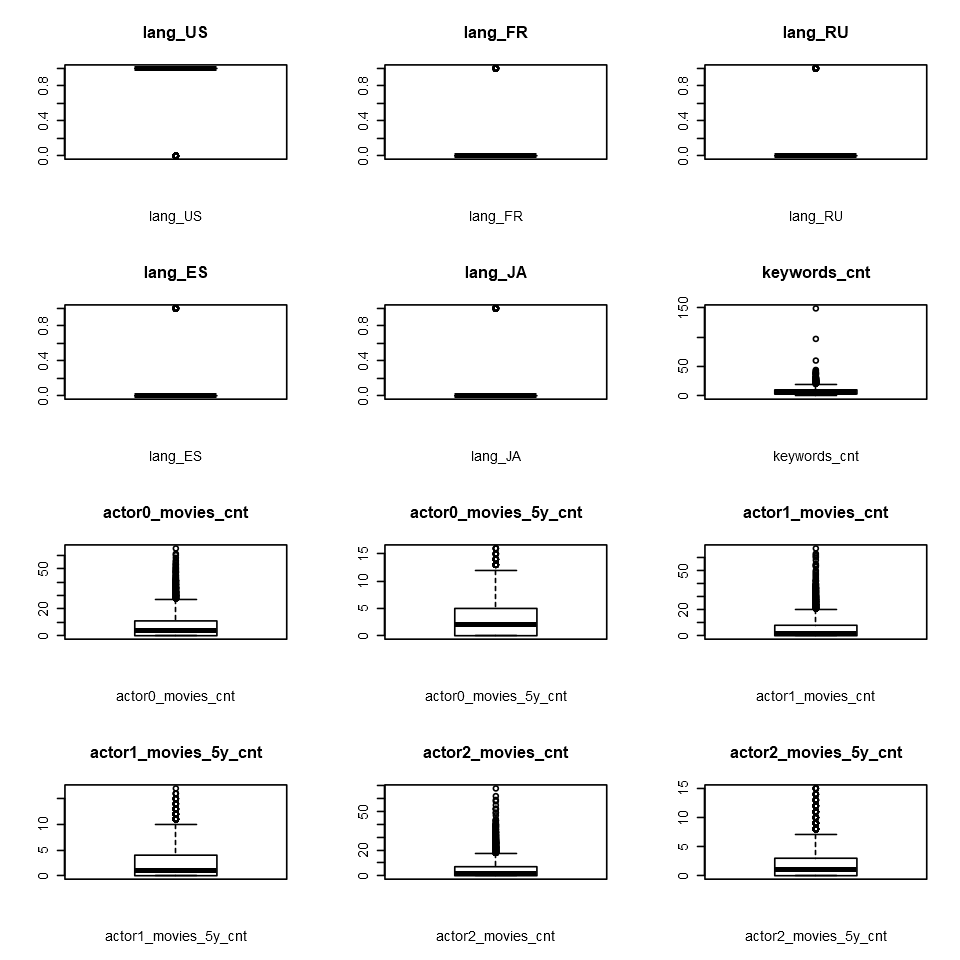

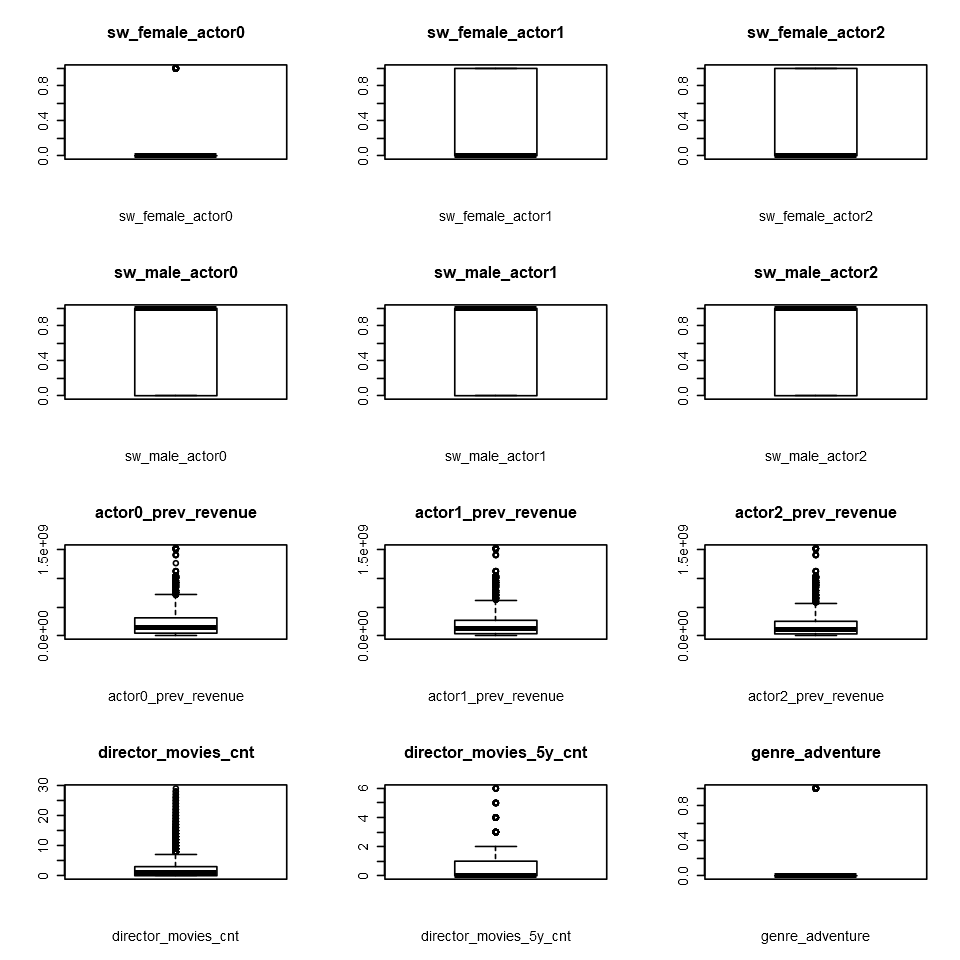

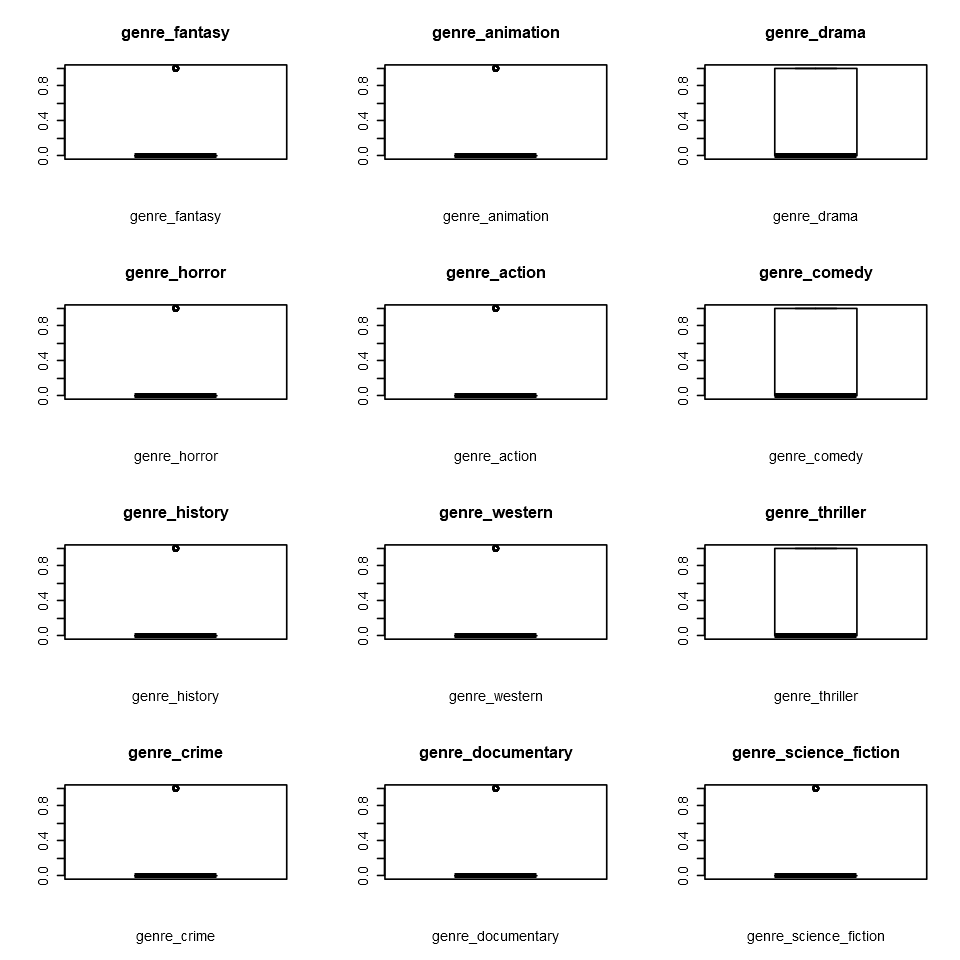

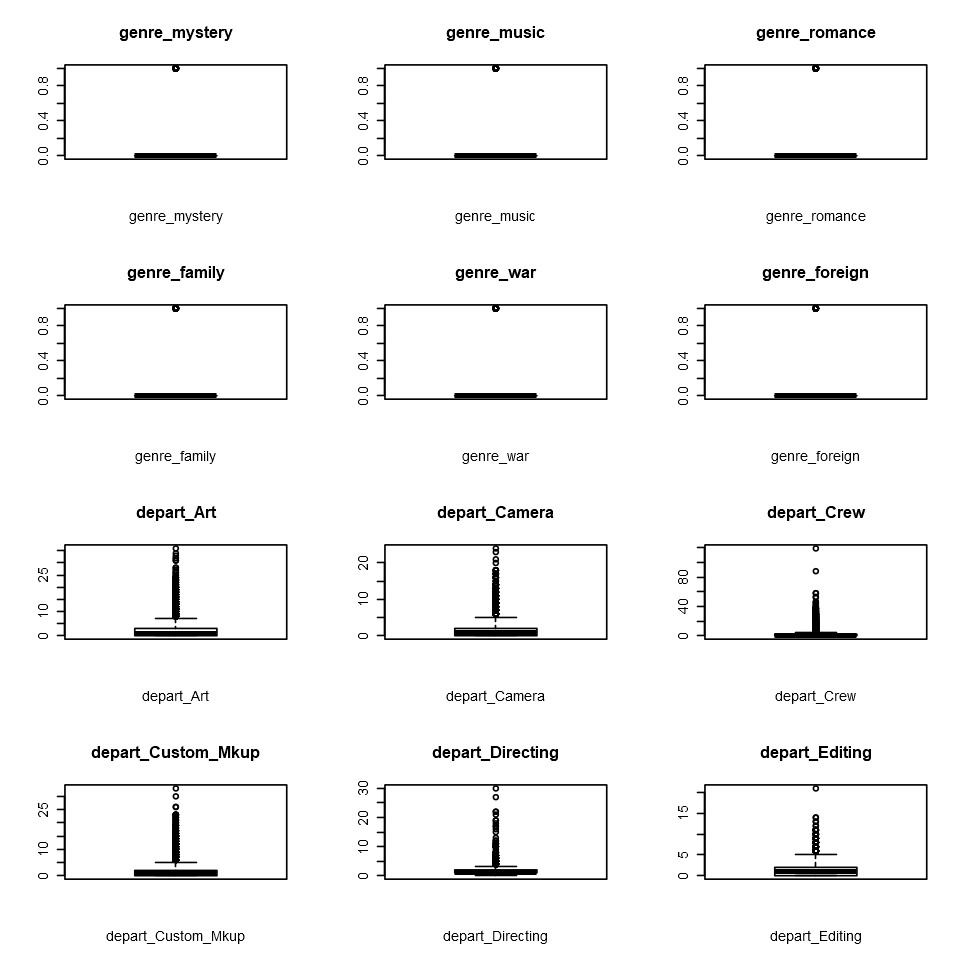

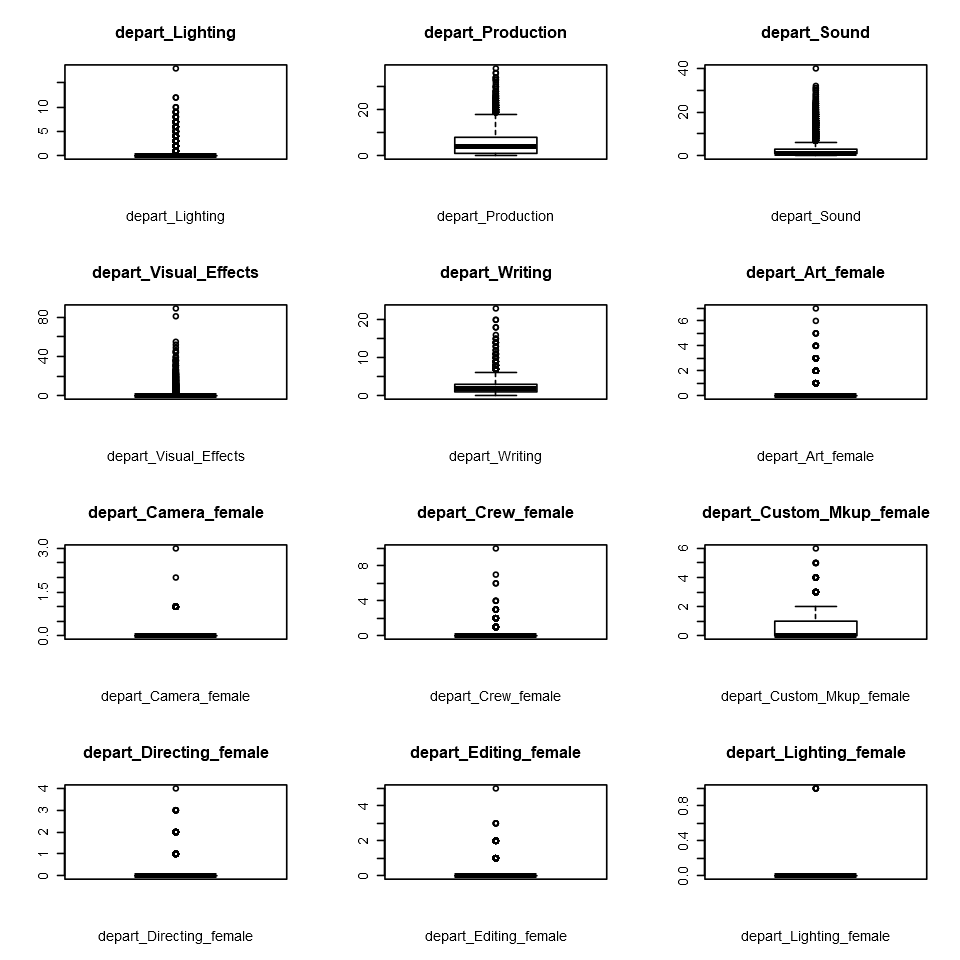

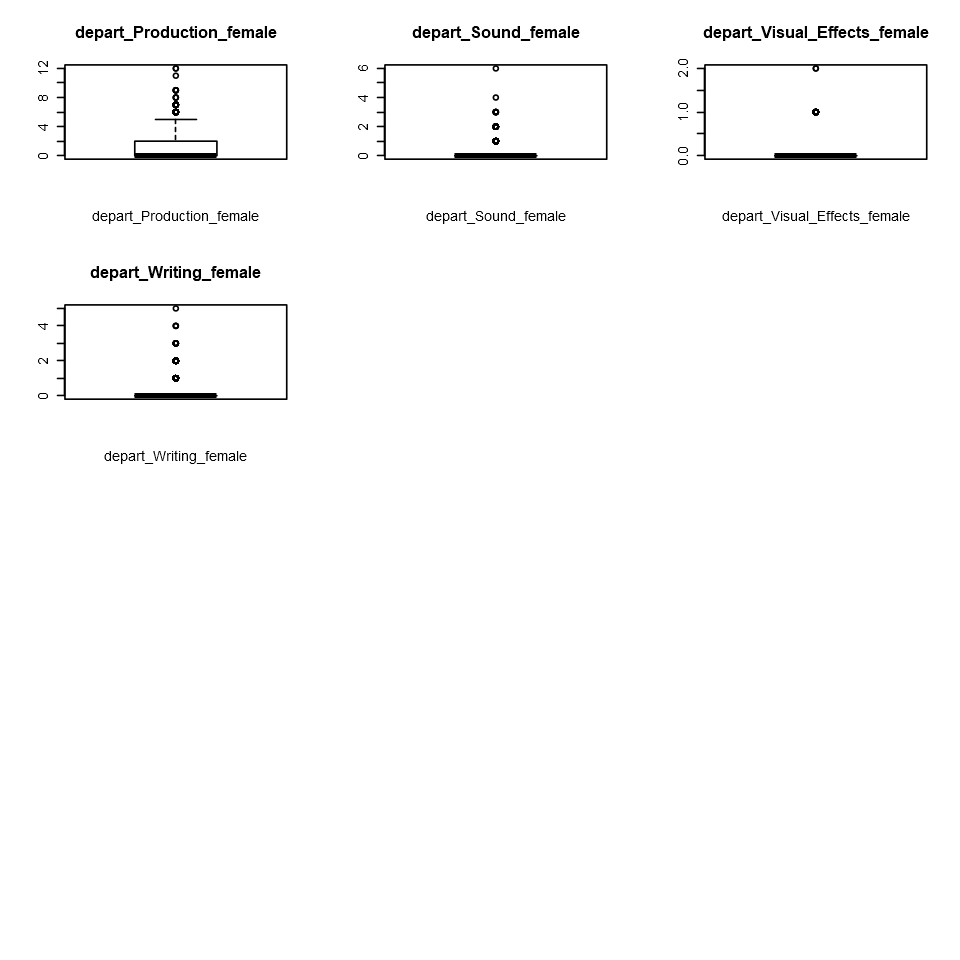

In [65]:

options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
nm <- names(BoxOffice[,1:85])
for(i in 10:85){
    x<-BoxOffice[,i]
    boxplot (x,xlab=nm[i],main=nm[i])
    }



In [67]:
options(repr.plot.width = 8, repr.plot.height = 8)
par(mfrow=c(4,3))
for(v in names(BoxOffice[,2:85])) {
    scatter.smooth(BoxOffice[[v]] ~ BoxOffice$species, main=v, xlab="BoxOffice",ylab=v, family="symmetric",
                  lpars =list(col = "red", lwd = 2, lty = 2))
}
par(mfrow=c(1,1))

ERROR: Error in xy.coords(x, y, xlabel, ylabel): 'x' and 'y' lengths differ


In [58]:
movies<- movies_ff %>% 
select( movie_id,revenue,budget,popularity,runtime)

movies
 

movie_id,revenue,budget,popularity,runtime
<int>,<int>,<int>,<dbl>,<dbl>
1,12314651,14000000,6.575393,93
2,95149435,40000000,8.248895,113
3,13092000,3300000,64.299990,105
4,16000000,1200000,3.174936,122
5,3923970,0,1.148070,118
6,3261638,8000000,0.743274,83
7,85446075,14000000,7.286477,92
8,2586511,0,1.949044,84
9,34327391,0,6.902423,100


In [60]:
corr_m <- cor(movies,y=NULL,)
head(corr[, 1:4])


ERROR: Error in head(corr[, 1:4]): object 'corr' not found


In [68]:

miss1 <- TestMCARNormality(data=BoxOffice, , del.lesscases = 1, imputation.number = 10)
summary(miss1)


ERROR: Error in t(yo) %*% yo: requires numeric/complex matrix/vector arguments
